In [1]:
%matplotlib inline
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [2]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

In [3]:
# "output-images"フォルダを作成（既にあるならそれで良し）
os.makedirs("output-images", exist_ok=True)
os.makedirs("parameters", exist_ok=True)

## innovationの推定量$\hat\varepsilon_{t_0}|\{X_{t}\}_{t=t_0-p}^{t_0}$の分布$P_{\hat\varepsilon_{t_0}|\{X_{t}\}_{t=t_0-p}^{t_0}}$を調べる

### $_{データセット}文字^{モデル構造}_{次元}$

$p^{\ast}=7$, $\phi^{\ast}=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]$, $\mu^{\ast}=0$, $\sigma^{\ast}=2$, $_{train}T=1000$<br>
に従うARモデルから生成されるデータをランダムseedのindexが0~99の$n=100$セット作成する。

In [4]:
phi_ast=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]
p_ast=len(phi_ast)
mu_ast=0
sigma_ast=2

In [5]:
trainT=1000
n=100
data_index = range(n)

In [6]:
trainDataSets=[]
for seed in data_index:
    trainData = tsModel.SARIMA(a=phi_ast, N=trainT, random_seed=seed, mu=mu_ast, sigma=sigma_ast)
    trainDataSets.append(trainData)
#     plt.plot(trainData)
#     plt.show()

こいつらが訓練データ

### 学習する推定モデルの形状や学習方法なんかを決定します

In [7]:
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
# ランダムシードについて
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--discriminator_seed", type=int, default=0, help="discriminatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
parser.add_argument("--data_seed", type=int, default=0, help="Dataの作成に用いる乱数のseed")
# 学習方法について
parser.add_argument("--n_epochs", type=int, default=20000, help="Discriminatorを学習させる回数")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--lr", type=float, default=0.00005, help="学習率")
parser.add_argument("--n_critic", type=int, default=5, help="一度generatorを更新するごとに何回discriminatorを更新するか")
parser.add_argument("--discriminator_hidden_unit", type=int, default=64, help="discriminatorの隠れ層のニューロンの数")
parser.add_argument("--withGP", type=bool, default=True, help="clipingの代わりにGradient Penaltyを加えるかどうか。True/False")
parser.add_argument("--withCorr", type=bool, default=False, help="Generatorの出力がbatch方向に無相関になるようなロスを加えるかどうか。　True/False")
# モデルの保存やLossの可視化について
parser.add_argument("--sample_interval", type=int, default=1000, help="epochを何回まわす度にモデルの保存を行うか")

try:
    opt = parser.parse_args() # .pyの場合はこちらを使用(.ipynbの場合エラーになります)
except:
    opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用

opt.n_epochs=1
opt.withCorr=True

# Gradient PenaltyをLossに加える際の重みの設定
if opt.withGP:
    default_weight=1.0
    gp_weight = input("Gradient PenaltyをLossに加える時の重みを入力してください。(defaultは{0})：".format(default_weight))
    try:
        gp_weight = float(gp_weight)
        if gp_weight<0:
            gp_weight = default_weight
    except:
        gp_weight=default_weight
    print("Gradient PenaltyのLoss内での重みは{0}です。".format(gp_weight))
else:
    clip_value = input('discriminatorのパラメータをclipする値(正の数)を入力してください(defaultは0.01)：')
    try:
        clip_value=float(clip_value)
        if clip_value<=0:
            clip_value=0.01
    except:
        clip_value=0.01
    print("clip値は",clip_value,"です。")
    gp_weight=0
    
# 相関係数の制約をLossに加える際の重みの設定
default_weight = 1.0
if opt.withCorr:
    corr_weight= input("相関係数の制約をLossに加える時の重みを入力してください。(defaultは{0})：".format(default_weight))
    try:
        corr_weight = float(corr_weight)
        if corr_weight<0:
            corr_weight = default_weight
    except:
        corr_weight=default_weight
    print("相関係数に関する制約のLoss内での重みは{0}です。".format(corr_weight))
else:
    corr_weight=0

# Gradient Penalty項の計算
def gradient_penalty(generated_data, real_data, gp_weight=10):

    batch_size = real_data.size()[0]

    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    if cuda:
        alpha=alpha.to(device)

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if cuda:
        interpolated=interpolated.to(device)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).to(device) if cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)# これいらないかも...
    
    # gradients_norm = (gradients.norm(2, dim=1) - 1) ** 2
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)# 0除算を防ぐ？

    return gp_weight * ((gradients_norm - 1) ** 2).mean()

def corr(x):
    return (((x-x.mean())*(x-x.mean()).T)*(1-torch.eye(x.shape[0],x.shape[0]).to(device))).sum()/2/x.shape[0]

usage: ipykernel_launcher.py [-h] [--generator_seed GENERATOR_SEED]
                             [--discriminator_seed DISCRIMINATOR_SEED]
                             [--predictor_seed PREDICTOR_SEED]
                             [--training_seed TRAINING_SEED]
                             [--data_seed DATA_SEED] [--n_epochs N_EPOCHS]
                             [--batch_size BATCH_SIZE] [--lr LR]
                             [--n_critic N_CRITIC]
                             [--discriminator_hidden_unit DISCRIMINATOR_HIDDEN_UNIT]
                             [--withGP WITHGP] [--withCorr WITHCORR]
                             [--sample_interval SAMPLE_INTERVAL]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1165/jupyter/kernel-0c83137f-0d1b-4b54-b94d-992d57f0a15b.json


Gradient PenaltyをLossに加える時の重みを入力してください。(defaultは1.0)：1
Gradient PenaltyのLoss内での重みは1.0です。
相関係数の制約をLossに加える時の重みを入力してください。(defaultは1.0)：1
相関係数に関する制約のLoss内での重みは1.0です。


In [8]:
# gpuが使えるかどうか
cuda = True if torch.cuda.is_available() else False
if cuda:
    print("GPUが使えます。")
    use_gpu = input('GPUを使いますか？ （Yes：1, No：0）  ----> ')
    cuda = bool(int(use_gpu))
else:
    print("GPUは使えません。")
    
if cuda:
    gpu_id = input('使用するGPUの番号を入れてください : ')
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
device = torch.device('cuda:'+gpu_id if cuda else 'cpu')

GPUが使えます。
GPUを使いますか？ （Yes：1, No：0）  ----> 0


### 推定モデルの決定

#### $p=7$

In [9]:
p=7

In [10]:
os.makedirs("output-images/p{0}".format(p), exist_ok=True)
os.makedirs("parameters/p{0}".format(p), exist_ok=True)

In [11]:
torch.manual_seed(opt.generator_seed)
generator = models.LinearGenerator(p = p, input_dim=1, is_bias=False)

In [12]:
# 入出力のチェック
a= torch.rand([opt.batch_size,1, p+1])
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([64, 1, 8])
output size: torch.Size([64, 1])


In [13]:
torch.manual_seed(opt.discriminator_seed)
discriminator = models.Discriminator(q=0, discriminator_hidden_unit=opt.discriminator_hidden_unit)

In [14]:
# 入出力のチェック
a= torch.rand([opt.batch_size, 1])
print("input size   :",a.shape)
b = discriminator(a)
print("output size:",b.shape)

input size   : torch.Size([64, 1])
output size: torch.Size([64, 1])


In [15]:
torch.manual_seed(opt.predictor_seed)
predictor = models.LinearPredictNet(p=p, input_dim=1, is_bias=True)

In [16]:
# 入出力のチェック
a= torch.rand([opt.batch_size,1, p+1])
print("input size   :",a.shape)
b = predictor(a)
print("output size:",b.shape)

input size   : torch.Size([64, 1, 8])
output size: torch.Size([64, 1])


####  訓練データセットを一つ取ってきて、学習してみる

seedが0の訓練データ

In [17]:
dataSeed=opt.data_seed
dataSeed

0

こいつをtrain:validation=900:100に分割する

In [18]:
Data = trainDataSets[dataSeed]
Data = torch.tensor(Data, dtype=torch.float)
Data=Data.view(1,-1)
trainData = Data[:,:900]
valData = Data[:,900:]

trainDataとvalDataを$\{X_t\}_{t=t_0-p}^{t_0}$ごとに取り出しやすいようにMatrixに変換する

In [19]:
trainMatrix = []
for i in range(trainData.shape[1]-(p)):
    ans = trainData[:,i:i+p+1].view(1,Data.shape[0],-1)
    trainMatrix.append(ans)
trainMatrix = torch.cat(trainMatrix)
trainMatrix.shape

torch.Size([893, 1, 8])

In [20]:
valMatrix = []
for i in range(valData.shape[1]-(p)):
    ans = valData[:,i:i+p+1].view(1,Data.shape[0],-1)
    valMatrix.append(ans)
valMatrix = torch.cat(valMatrix)
valMatrix.shape

torch.Size([93, 1, 8])

##### 学習

In [21]:
# Optimizers(パラメータに対して定義される)
optimizer_G = torch.optim.RMSprop(params=generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(params=discriminator.parameters(), lr=opt.lr)
optimizer_F = torch.optim.Adam(params=predictor.parameters())

In [22]:
mseLoss = nn.MSELoss()# 二条誤差MSE

In [23]:
# パラメータと学習データをGPUに乗っける
generator.to(device)
discriminator.to(device)
predictor.to(device)

mseLoss.to(device)

trainMatrix=trainMatrix.to(device)
valMatrix=valMatrix.to(device)

In [24]:
saveModel = input('作成したモデルを{0}epochごとに逐次保存しますか？ （Yes：1, No：0）  ----> '.format(opt.sample_interval))
saveModel = bool(int(saveModel))

作成したモデルを1000epochごとに逐次保存しますか？ （Yes：1, No：0）  ----> 0


In [25]:
batches_done = 0
generator_done = 0# generatorを学習した回数
predictor_done = 0

# グラフ描画用
loss_D_curve = []
loss_G_curve = []
loss_F_curve = []
val_loss_D_curve = []
val_loss_G_curve = []
val_loss_F_curve = []
p_value = []

# 訓練データの時系列のどの時刻を学習に用いるかをランダムにしているが、そのランダムシードを固定する
random.seed(a=opt.training_seed)

start=time.time()
for epoch in range(1, opt.n_epochs+1):# epochごとの処理(discriminatorのepoch)
    
    # epochごとにbatchで計算したlossを平均した値をloss_curveとして描きたい
    loss_D_list = []
    loss_G_list = []
    loss_F_list = []
    
    # batchの処理は、0~892をランダムに並び替えたリストbatch_sampleを作成し、ここからbatch×(p+1)の学習データを一つづつ獲得する
    l=list(range(trainMatrix.shape[0]-opt.batch_size))
    batch_sample = random.sample(l, len(l))
    for i, batch in enumerate(batch_sample):
        
        X = trainMatrix[batch : batch+opt.batch_size]# torch.Size([64, 1, 8]) (batch, dim, p+1)
        X = Variable(X)# 自動微分可能に。(もういらないらしい？)
        
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        for param in discriminator.parameters(): # discriminatorの勾配の更新をONにする
            param.requires_grad = True 
            
        if not opt.withGP:
            # discriminatorのパラメタをクリップする（全てのパラメタの絶対値がclip_value以下の値になる）
            for param in discriminator.parameters():
                param.data.clamp_(-clip_value, clip_value)

        # discriminatorの勾配情報を0に初期化する
        optimizer_D.zero_grad()
        
        # 現在＋過去p時刻分の時系列をgeneratorで変換した値を取得
        hat_normeps_t = generator(X)#.detach() # torch.Size([64, 4])
        
        # generatorの出力と同じ大きさの標準正規分布からのサンプルを作成
        normeps_t = Variable(torch.randn_like(hat_normeps_t))
        
        # Adversarial loss すなわちWasserstein距離の符号を反転させたもの。（DiscriminatorはWasserstein距離を最大にする関数になりたい）
        loss_D = -torch.mean(discriminator(normeps_t)) + torch.mean(discriminator(hat_normeps_t))
        # GPも加えとく
        if opt.withGP:
            loss_D = loss_D + gradient_penalty(generated_data=hat_normeps_t, real_data=normeps_t, gp_weight=gp_weight) 
        loss_D_list.append(float(loss_D))
        
        # loss_Dを目的関数としてネットワークの全パラメータで微分をしてくれと言う合図、つまり今回ならdiscriminatorとgeneratorのパラメータの微分値を書き換えてくれということ
        loss_D.backward()
        # otimizerにしたがってパラメタを更新
        optimizer_D.step()
        
        
        # -----------------
        #  Train Generator
        # -----------------
        
        # discriminatorをopt.n_critic回学習させるごとに一回generatorを学習させる(ただし最初はめっちゃdiscriminatorを優先させる)
        if batches_done % (100 if generator_done<25 or generator_done%500==0 else opt.n_critic) == 0:
            
            for param in discriminator.parameters():
                param.requires_grad = False # discriminatorの勾配の更新をOFFにする

            # generatorの勾配情報を0に初期化(discriminatorの学習時に勾配情報が更新されてしまっているため)
            optimizer_G.zero_grad()

            # 現在＋過去p時刻分の時系列をgeneratorで変換した値を取得(もう一回取得する必要があるのかな...?)
            hat_normeps_t = generator(X)# torch.Size([64, 4])

            # Adversarial loss(discriminatorの出力の期待値を大きくして、つまりWasserstein距離の第二項を大きくして、Wasserstein距離小さくしたい)
            loss_G = -torch.mean(discriminator(hat_normeps_t))
            # ここに相関係数を小さくするロスも加える？
            if opt.withCorr:
                loss_G = loss_G + corr_weight*corr(hat_normeps_t)
            loss_G_list.append(float(loss_G))
            
            # loss_Gを目的関数としてネットワークの全パラメータで微分をしてくれと言う合図
            loss_G.backward()
            # generatorのパラメータをその微分値とoptimizerを使って更新してくれ！
            optimizer_G.step()
            
            generator_done+=1

        
        # -----------------
        #  Train Predictor
        # -----------------
        
        # discriminatorをopt.n_critic回学習させるごとに一回predictorを学習させる(ただし最初はめっちゃdiscriminatorを優先させる)
        if batches_done % (100 if predictor_done<25 or predictor_done%500==0 else opt.n_critic) == 0: # とりあえずgeneratorと同じ？
        
            # predictorの勾配情報を0に初期化(一応。前回の更新時の勾配情報をなくすため？)
            optimizer_G.zero_grad()
            optimizer_F.zero_grad()

            # 正規化されたinnoationの推定量をgeneratorを用いて算出
            hat_normeps_t = generator(X)
            # これと過去p時刻の時系列の値（X_{t-1}, .... , X_{t-p}）をpredictorへ入力
            input_tensor = torch.cat([hat_normeps_t.view(opt.batch_size, -1, 1), X[:,:,:-1]], dim=2)
            prediction = predictor(input_tensor)
            
            loss_F = mseLoss(prediction, X[:,:,-1])
            loss_F_list.append(float(loss_F))
            
            
            loss_F.backward()
            optimizer_F.step()
            optimizer_G.step()
            
            predictor_done+=1
        batches_done+=1

    print("epoch：{0}/{1}   batch：{2:003}/{3}   loss_D：{4: .4f}   loss_G：{5: .4f}   loss_F：{6: .4f}   経過時間：{7: .1f}秒".format(epoch, opt.n_epochs, i+1, len(batch_sample), round(float(loss_D), 4), round(float(loss_G), 4), round(float(loss_F), 4), time.time()-start))
            
    if saveModel and epoch % opt.sample_interval == 0:
        torch.save(generator.state_dict(), 'parameters/p'+str(p)+'/generator_epoch{0}_batchSize{1}_GP{2}_Corr{3}_DataSeed{4}.pth'.format(epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
        torch.save(discriminator.state_dict(), 'parameters/p'+str(p)+'/discriminator_epoch{0}_batchSize{1}_GP{2}_Corr{3}_DataSeed{4}.pth'.format(epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
        torch.save(predictor.state_dict(), 'parameters/p'+str(p)+'/predictor_epoch{0}_batchSize{1}_GP{2}_Corr{3}_DataSeed{4}.pth'.format(epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))

    # epochごとにbatchで計算したlossを平均した値をloss_curveとして描きたい
    loss_D_curve.append(sum(loss_D_list)/len(loss_D_list))
    loss_G_curve.append(sum(loss_G_list)/len(loss_G_list))
    loss_F_curve.append(sum(loss_F_list)/len(loss_F_list))
    
    # validationデータによるlossも計算したい
    val_hat_normeps_t = generator(valMatrix)
    val_normeps_t = torch.randn_like(val_hat_normeps_t)
    val_input_tensor = torch.cat([val_hat_normeps_t.view(-1, 1,1), valMatrix[:,:,:-1]], dim=2)
    
    val_loss_D = -torch.mean(discriminator(val_normeps_t)) + torch.mean(discriminator(val_hat_normeps_t))
    if opt.withGP:
        val_loss_D = val_loss_D + gradient_penalty(generated_data=val_hat_normeps_t, real_data=val_normeps_t, gp_weight=gp_weight) 
    val_loss_D_curve.append(float(val_loss_D))
    
    val_loss_G = -torch.mean(discriminator(val_hat_normeps_t))
    if opt.withCorr:
        val_loss_G = val_loss_G + corr_weight*corr(val_hat_normeps_t)
    val_loss_G_curve.append(float(val_loss_G))
    
    val_loss_F = mseLoss(predictor(val_input_tensor), valMatrix[:,:,0])
    val_loss_F_curve.append(float(val_loss_F))
    
    if epoch % 10==0:
        plt.figure(figsize=(13,8))
        plt.title("DiscriminatorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_D_curve, label="training")
        plt.plot(val_loss_D_curve, label="validation")
        plt.legend()
        plt.savefig("dloss.png")
        plt.close()

        plt.figure(figsize=(13,8))
        plt.title("GeneratorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_G_curve, label="training")
        plt.plot(val_loss_G_curve, label="validation")
        plt.legend()
        plt.savefig("gloss.png")
        plt.close()
        
        plt.figure(figsize=(13,8))
        plt.title("PredictorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_F_curve, label="training")
        plt.plot(val_loss_F_curve, label="validation")
        plt.legend()
        plt.savefig("floss.png")
        plt.close()
    
#     break
torch.save(generator.state_dict(), 'parameters/p'+str(p)+'/generator_epoch{0}_batchSize{1}_GP{2}_Corr{3}_DataSeed{4}.pth'.format(epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
torch.save(discriminator.state_dict(), 'parameters/p'+str(p)+'/discriminator_epoch{0}_batchSize{1}_GP{2}_Corr{3}_DataSeed{4}.pth'.format(epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
torch.save(predictor.state_dict(), 'parameters/p'+str(p)+'/predictor_epoch{0}_batchSize{1}_GP{2}_Corr{3}_DataSeed{4}.pth'.format(epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))


epoch：1/1   batch：829/829   loss_D：-0.1187   loss_G： 0.1626   loss_F： 3.3732   経過時間： 3.4秒


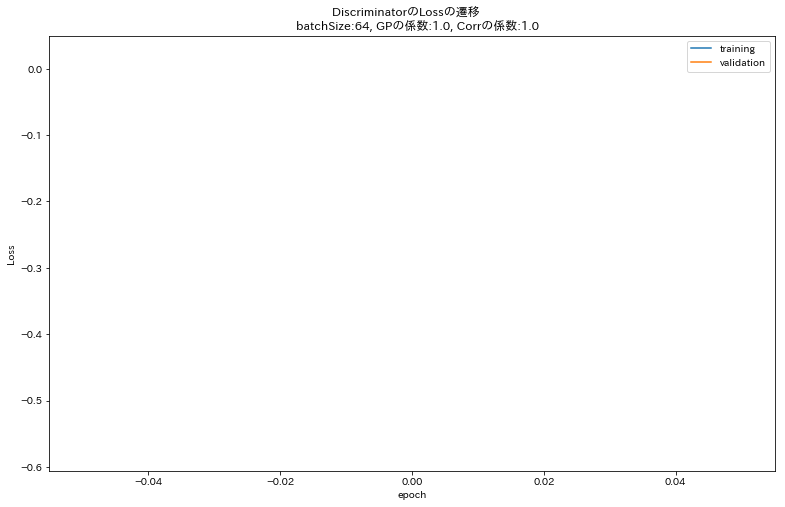

In [26]:
plt.figure(figsize=(13,8))
plt.title("DiscriminatorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_D_curve, label="training")
plt.plot(val_loss_D_curve, label="validation")
plt.legend()
plt.savefig("output-images/p{0}/dloss_epoch{1}_batchSize{2}_GP{3}_Corr{4}_DataSeed{5}.png".format(p, epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
plt.show()
plt.close()

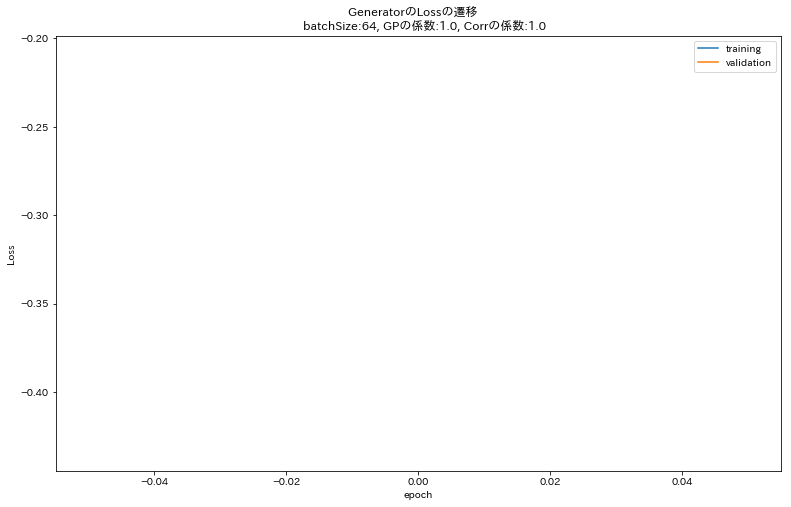

In [27]:
plt.figure(figsize=(13,8))
plt.title("GeneratorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_G_curve, label="training")
plt.plot(val_loss_G_curve, label="validation")
plt.legend()
plt.savefig("output-images/p{0}/gloss_epoch{1}_batchSize{2}_GP{3}_Corr{4}_DataSeed{5}.png".format(p, epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
plt.show()
plt.close()

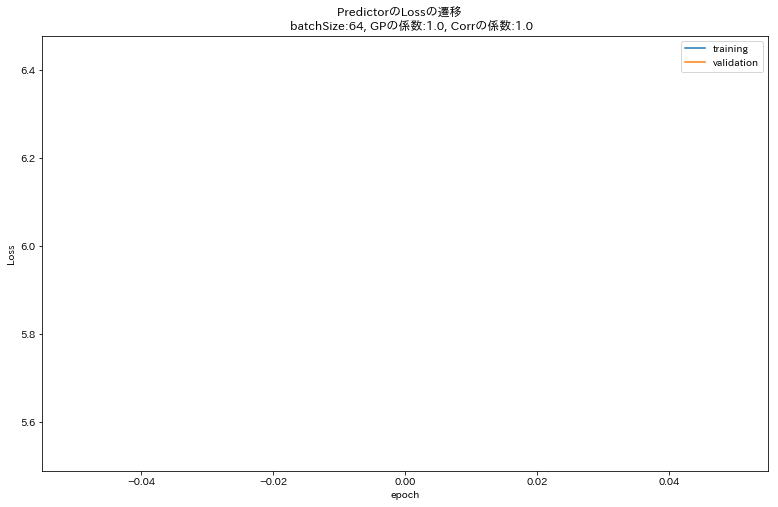

In [28]:
plt.figure(figsize=(13,8))
plt.title("PredictorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_F_curve, label="training")
plt.plot(val_loss_F_curve, label="validation")
plt.legend()
plt.savefig("output-images/p{0}/floss_epoch{1}_batchSize{2}_GP{3}_Corr{4}_DataSeed{5}.png".format(p, epoch, opt.batch_size, int(gp_weight), int(corr_weight), dataSeed ))
plt.show()
plt.close()